In [1]:
import random
import numpy as np

In [16]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(300):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [3]:
# env.observation_space

In [4]:
num_episodes = 2000
epsilon_start = 1.0
epsilon_end   = 0.05
epsilon_decay = 0.995   # multiply each step
epsilon = epsilon_start
c = 4
gamma = 0.995
alpha = 0.001
tau = 0.01
mini_batch_size = 64
memory_buffer_warmup = 1000
memory_buffer_size = 100000

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
q_network = models.Sequential([
    layers.Input(shape=(8,)),        # 8 input features (neurons)
    layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons
    layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
    layers.Dense(4, activation='linear') # Output layer with 4 neurons
])

# Compile the model
q_network.compile(optimizer='adam',
              loss=tf.keras.losses.Huber()   # or 'sparse_categorical_crossentropy' if labels are ints
)

# Show model summary
q_network.summary()

/Users/mee/Documents/Projects/Machine-Learning-Specialization/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/mee/Documents/Projects/Machine-Learning-Specialization/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/mee/Documents/Projects/Machine-Learning-Specialization/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
target_q_network = tf.keras.models.clone_model(q_network)
target_q_network.build(q_network.input_shape)
target_q_network.set_weights(q_network.get_weights())


In [7]:
memory_buffer = []

In [8]:
def learning_update(q_network, target_q_network, memory_buffer, gamma):
    mini_batch = random.sample(memory_buffer, mini_batch_size)

    observations, actions, rewards, dones, next_observations = (
        np.vstack([s for (s, _, _, _, _) in mini_batch]).astype(np.float32),
        np.array([a for (_, a, _, _, _) in mini_batch]).astype(np.int32),
        np.array([r for (_, _, r, _, _) in mini_batch]).astype(np.float32),
        np.array([d for (_, _, _, d, _) in mini_batch]).astype(np.float32),
        np.vstack([ns for (_, _, _, _, ns) in mini_batch]).astype(np.float32),
    )
    next_q = target_q_network.predict_on_batch(next_observations)
    targets = rewards + gamma * np.max(next_q, axis=1) * (1 - dones)

    q_curr = q_network.predict_on_batch(observations)
    q_curr[np.arange(mini_batch_size), actions] = targets
    q_network.train_on_batch(observations, q_curr)

    # Soft update of target network
    target_weights = target_q_network.get_weights()
    main_weights = q_network.get_weights()
    updated_weights = [tau * main_w + (1 - tau) * target_w for main_w, target_w in zip(main_weights, target_weights)]
    target_q_network.set_weights(updated_weights)

In [9]:
# Evaluation function
def evaluate_policy(env, q_network, episodes=5, epsilon_eval=0.01):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done, ep_ret = False, 0.0
        while not done:
            if np.random.random() < epsilon_eval:
                act = env.action_space.sample()
            else:
                q = q_network.predict(obs.reshape(1, -1), verbose=0)
                act = int(np.argmax(q[0]))
            obs, r, term, trunc, _ = env.step(act)
            done = term or trunc
            ep_ret += r
        scores.append(ep_ret)
    return float(np.mean(scores))

In [10]:
from collections import deque


memory_buffer = deque(maxlen=memory_buffer_size)   # O(1) append/drop
returns = []
ep_lens = []
c_count = 0
eval_interval = 500
present_interval = 100
for i in range(num_episodes):
    observation, info = env.reset()
    done, ep_return, ep_len = False, 0.0, 0

    while not done:
        
        # Policy
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = q_network(observation.reshape(1, -1), training=False).numpy()
            action = int(np.argmax(q_values[0]))

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_return += reward
        ep_len += 1
        
        # Store the experience in the memory buffer
        memory_buffer.append((observation, action, reward, done, next_observation))

        if c_count >= c and len(memory_buffer) >= memory_buffer_warmup:
            c_count = 0
            learning_update(q_network, target_q_network, memory_buffer, gamma)
        else:
            c_count += 1

        observation = next_observation

    epsilon = max(epsilon * epsilon_decay, epsilon_end)

    returns.append(ep_return)
    ep_lens.append(ep_len)
    if (i + 1) % present_interval == 0:
        print(f"Episode {i} finished. Average return over last {present_interval} episodes: {np.mean(returns[-present_interval:])} and length {np.mean(ep_lens[-present_interval:])}, epsilon: {epsilon}")
    
    if (i + 1) % eval_interval == 0:
        eval_score = evaluate_policy(env, q_network, epsilon_eval=0.01)
        print(f"Evaluation score: {eval_score}")

env.close()

Episode 99 finished. Average return over last 100 episodes: -109.19176137034776 and length 123.43, epsilon: 0.6057704364907278
Episode 199 finished. Average return over last 100 episodes: -42.75170393100741 and length 327.15, epsilon: 0.3669578217261671
Episode 299 finished. Average return over last 100 episodes: -29.996277886180177 and length 761.69, epsilon: 0.22229219984074702
Episode 399 finished. Average return over last 100 episodes: -15.015724431870403 and length 932.32, epsilon: 0.1346580429260134
Episode 499 finished. Average return over last 100 episodes: 39.97410300571915 and length 526.17, epsilon: 0.08157186144027828
Evaluation score: 146.85662974057928
Episode 599 finished. Average return over last 100 episodes: 28.477535394312255 and length 756.79, epsilon: 0.05
Episode 699 finished. Average return over last 100 episodes: 214.00787004494111 and length 454.81, epsilon: 0.05
Episode 799 finished. Average return over last 100 episodes: 199.03707389785774 and length 329.19, 

KeyboardInterrupt: 

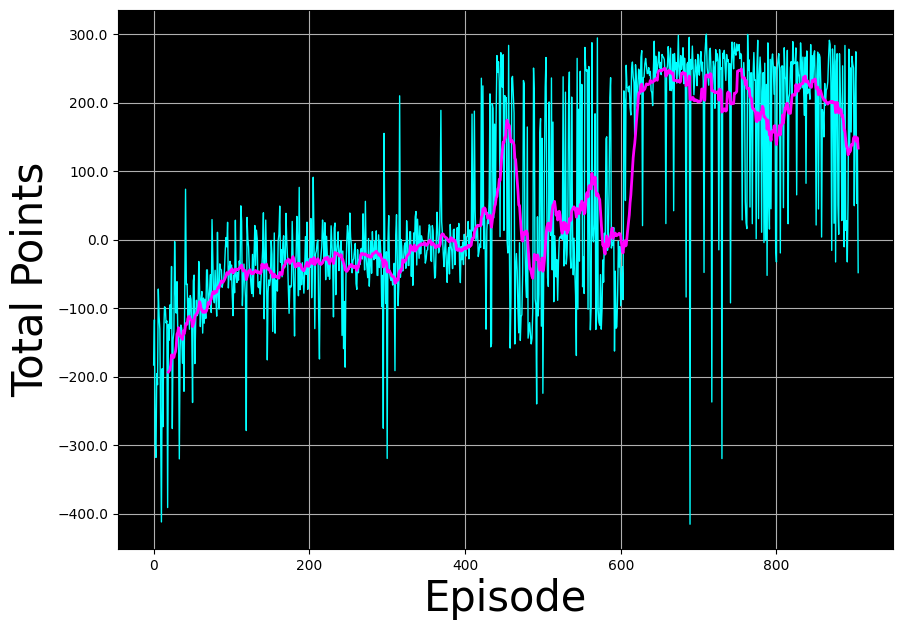

In [11]:
from utils import plot_history
plot_history(returns, rolling_window=20)


In [17]:
env_render = gym.make("LunarLander-v3", render_mode="human")
observation, info = env_render.reset(seed=42)

for _ in range(1000):
    # this is where you would insert your policy
    action = np.argmax(q_network.predict(observation.reshape(1, -1), verbose=0)[0])

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env_render.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env_render.reset()

env_render.close()

In [ ]:
env_render.close()